$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
$$
# Part 3: Convolutional Architectures
<a id=part3></a>

In this part we will explore convolution networks and the effects of their architecture on accuracy. We'll implement a common block-based deep CNN pattern and we'll perform various experiments on it while varying the architecture. Then we'll implement our own custom architecture to see whether we can get high classification results on a large subset of CIFAR-10.

Training will be performed on GPU.

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf

%matplotlib inline
%load_ext autoreload
%autoreload 2

seed = 42
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

## Convolutional layers and networks
<a id=part3_1></a>

Convolutional layers are the most essential building blocks of the state of the art deep learning image classification models and also play an important role in many other tasks.
As we saw in the tutorial, convolutional layers operate on and produce volumes (3D tensors) of activations.


One way to think about them is as if the neurons are organized in a 3D grid,
where neurons at the same depth share weights (represented here as colors).
Contrary to fully connected (affine) layers, neurons in convolutional layers are **not** connected to each of the activations of the previous layer.
Instead, each neuron is connected only to a small region of the input volume e.g. a 5x5x$C_{\mathrm{in}}$ slice
(where $C_{\mathrm{in}}$ is the input volume's depth).

<img src="imgs/depthcol.jpeg" />

Another way to interpret convolutional layers is as a collection of 3D learnable filters,
each of which operates on a small spatial region of the input volume.
Each filter is convolved with the input volume ("slides over it"),
and a dot product is computed at each location followed by a non-linearity which produces one activation.
All these activations produce a 2D plane known as a **feature map**.
Multiple feature maps (one for each filter) comprise the output volume.

<img src="imgs/cnn_filters.png" width="600" />

A crucial property of convolutional layers is their translation invariance,
i.e. their ability to detect features regardelss of their spatial location in the input.

Convolutional network architectures usually follow a pattern basic repeating blocks: one or more convolution layers, each followed by a non-linearity (generally ReLU) and then a pooling layer to reduce spatial dimensions. Usually, the number of convolutional filters increases the deeper they are in the network.
These layers are meant to extract features from the input.
Then, one or more fully-connected layers is used to combine the extracted features into the required number of output class scores.

## Building convolutional networks with PyTorch
<a id=part3_2></a>

PyTorch provides all the basic building blocks needed for creating a convolutional arcitecture within the [`torch.nn`](https://pytorch.org/docs/stable/nn.html) package.
Let's use them to create a basic convolutional network with the following architecture pattern:

    [(CONV -> ReLU)*P -> MaxPool]*(N/P) -> (Linear -> ReLU)*M -> Linear

Here $N$ is the total number of convolutional layers,
$P$ specifies how many convolutions to perform before each pooling layer
and $M$ specifies the number of hidden fully-connected layers before the final output layer.

**TODO**: Complete the implementaion of the `ConvClassifier` class in the `hw3/models.py` module.

In [2]:
import hw3.models as models
torch.manual_seed(seed)

net = models.ConvClassifier((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

expected_out = torch.load('tests/assets/expected_conv_out.pt').to(device)
test.assertLess(torch.norm(test_out - expected_out).item(), 1e-5)

ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
)
out = tensor([[-0.0868, -0.3790, -0.4341, -0.1236, -0.2160,  0.1683,  0.4739,  0.0750,
          0.1151, -0.1606]], device='cuda:0', grad_fn=<AddmmBackward>)


**Note about running on GPUs**.

Notice how we called `.to(device)` on **both** the model and the input tensor.
Here the `device` is a `torch.device` object that we created above. If an nvidia GPU is available on the machine you're running this on, the `device` will be `'cuda'`. When you run `.to(device)` on a model, it recursively goes over all the model parameter tensors and copies their memory to the GPU. Similarly, calling `.to(device)` on the input image also copies it.

In order to train on a GPU, you need to make sure to move **all** your tensors to it. You'll get errors if you try to mix CPU and GPU tensors in a computation.

In [3]:
print(f'This notebook is running with device={device}')
print(f'The model parameter tensors are therefore also on device={next(net.parameters()).device}')
print(f'The test image is therefore also on device={test_image.device}')

This notebook is running with device=cuda
The model parameter tensors are therefore also on device=cuda:0
The test image is therefore also on device=cuda:0


Let's load CIFAR-10 again to use as our dataset.

In [4]:
data_dir = os.path.expanduser('~/.pytorch-datasets')
ds_train = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=True, transform=tvtf.ToTensor())
ds_test = torchvision.datasets.CIFAR10(root=data_dir, download=True, train=False, transform=tvtf.ToTensor())

print(f'Train: {len(ds_train)} samples')
print(f'Test: {len(ds_test)} samples')

x0,_ = ds_train[0]
in_size = x0.shape
num_classes = 10
print('input image size =', in_size)

Files already downloaded and verified
Files already downloaded and verified
Train: 50000 samples
Test: 10000 samples
input image size = torch.Size([3, 32, 32])


Now as usual, as a sanity test let's make sure we can overfit a tiny dataset with our model. But first we need to adapt our `Trainer` for PyTorch models.

**TODO**: Complete the implementaion of the `TorchTrainer` class in the `hw3/training.py` module.

In [5]:
import hw3.training as training
torch.manual_seed(seed)

# Define a tiny part of the CIFAR-10 dataset to overfit it
batch_size = 2
max_batches = 25
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=False)

# Create model, loss and optimizer instances
model = models.ConvClassifier(in_size, num_classes, filters=[32], pool_every=1, hidden_dims=[100])
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9,)

# Use TorchTrainer to run only the training loop a few times.
if str(device) == 'cuda':
    model.cuda()
trainer = training.TorchTrainer(model, loss_fn, optimizer, device)
best_acc = 0
for i in range(50):
    res = trainer.train_epoch(dl_train, max_batches=max_batches, verbose=(i%2==0))
    best_acc = res.accuracy if res.accuracy > best_acc else best_acc
    
# Test overfitting
test.assertGreaterEqual(best_acc, 95)

train_batch (Avg. Loss 0.000, Accuracy 100.0): 100%|██████████| 25/25 [00:00<00:00, 207.89it/s]


## Experimenting with model architectures
<a id=part3_3></a>

You will now perform a series of experiments that train various model configurations on a much larger part of the CIFAR-10 dataset.

To perform the experiments, you'll need to use a machine with a GPU since training time might be too long otherwise.


### General notes for running experiments

- You can run the experiments on a different machine and copy the results (files)
to the `results` folder on your local machine.
This notebook will only display the results, not run the actual experiment code (except for a demo run).

- It's important to give each experiment run a name as specified by the notebook instructions later on. The each run has a `run_name` parameter that will also be the name of the results file which this notebook will expect to load.

- You will implement the code to run the experiments in the `hw3/experiments.py` module. This module has a CLI parser so that you can invoke it as a script and pass in all the configuration parameters for a single experiment run.

- You should use `python -m hw3.experiments run-exp` to run an experiment, and **not** `python hw3/experiments.py run-exp`, regardless of how/where you run it.

### Experiment 1 - Network depth and number of filters

In this part we will test some different architecture configurations based on our `ConvClassifier`.
Specifically, we want to try different depths and number of features to see the effects these parameters have on the model's performance.

To do this, we'll define two extra hyperparameters for our model, `K` (`filters_per_layer`) and `L` (`layers_per_block`).
- `K` is a list, containing the number of filters we want to have in our conv layers.
- `L` is the number of consecutive layers with the same number of filters to use.

For example, if `K=[32, 64]` and `L=2` it means we want two conv layers with 32 filters followed by two conv layers with 64 filters. The feature-extraction part of our model will therefore be:

    Conv(X,32)->ReLu->Conv(32,32)->ReLU->MaxPool->Conv(32,64)->ReLU->Conv(64,64)->ReLU->MaxPool
    
We'll try various values of the `K` and `L` parameters in combination and see how each architecture trains. **All other hyperparameters are up to you**, including the choice of the optimization algorithm, the learning rate, regularization and architecture hyperparams such as `pad_every` and `hidden_dims`. You can try some manual runs to determine some good values for the hyperparameters or implement cross-validation to do it.
However, the **dataset size** you test on should be large. Use at least ~12000 training images and ~3000 validation images. The **batch size** parameter however is also up to you.

The important thing is that you state what you used, how you decided on it, and explain your results based on that.

First we need to write some code to run the experiment.

**TODO**:
1. Implement the `run_experiment()` function in the `hw3/experiments.py` module.
1. If you haven't done so already, it would be an excellent idea to implement the **early stopping** feature of the `Trainer` class.

The following block tests that your implementation works. It's also meant to show you that each experiment run creates a result file containing the parameters to reproduce and the `FitResult` object for plotting.

In [18]:
import hw3.experiments as experiments
from hw3.experiments import load_experiment
from helpers.plot import plot_fit

# Test experiment1 implementation on a few data samples and with a small model
experiments.run_experiment('test_run', seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                           filters_per_layer=[32], layers_per_block=16, pool_every=3, hidden_dims=[100])

# There should now be a file 'test_run.json' in your `results/` folder.
# We can use it to load the results of the experiment.
cfg, fit_res = load_experiment('results/test_run.json')
_, _ = plot_fit(fit_res)

# And `cfg` contains the exact parameters to reproduce it
print('experiment config: ', cfg)



################# EXPERIMENT 1.1 ########################
# K = [32,64]
# L = [2,4,8,16]
# for filters_per_lyr in K:
#     for layers_per_blk in L:
#         print("~~~~~~~~~~ RUNNING EXP 1.1 " + "K" + str(filters_per_lyr) + "_L" + str(layers_per_blk))
#         test_name = "exp1_1_K" + str(filters_per_lyr) + "_L" + str(layers_per_blk)
#         experiments.run_experiment(test_name, seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
#                            filters_per_layer=[filters_per_lyr], layers_per_block=layers_per_blk, pool_every=3, hidden_dims=[100])

################# EXPERIMENT 1.2 ########################
# K = [32,64,128,258]
# L = [2,4,8]
# for layers_per_blk in L:
#     for filters_per_lyr in K:
#         print("~~~~~~~~~~ RUNNING EXP 1.2 " + "K" + str(filters_per_lyr) + "_L" + str(layers_per_blk))
#         test_name = "exp1_2_L" + str(layers_per_blk) + "_K" + str(filters_per_lyr)
#         experiments.run_experiment(test_name, seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
#                            filters_per_layer=[filters_per_lyr], layers_per_block=layers_per_blk, pool_every=3, hidden_dims=[100])

################# EXPERIMENT 1.3 ########################
# K= [64, 128, 256]
# L = [1,2,3,4]

# for layers_per_blk in L:
#     print("~~~~~~~~~~ RUNNING EXP 1.3 " + "_L" + str(layers_per_blk))
#     test_name = "exp1_3_L" + str(layers_per_blk) + "_K64-128-256"
#     experiments.run_experiment(test_name, seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
#                        filters_per_layer=K, layers_per_block=layers_per_blk, pool_every=3, hidden_dims=[100])





~~~~~~~~~~ RUNNING EXP 1.2 K128_L4
Files already downloaded and verified
Files already downloaded and verified
ConvClassifier(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
  )
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=10, bias=True)
  )
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 32, 32]           3,584
            

We'll use the following function to load multiple experiment results and plot them together.

In [32]:
def plot_exp_results(filename_pattern, results_dir='results'):
    fig = None
    result_files = glob.glob(os.path.join(results_dir, filename_pattern))
    result_files.sort()
    if len(result_files) == 0:
        print(f'No results found for pattern {filename_pattern}.', file=sys.stderr)
        return
    for filepath in result_files:
        m = re.match('exp\d_(\d_)?(.*)\.json', os.path.basename(filepath))
        cfg, fit_res = load_experiment(filepath)
        fig, axes = plot_fit(fit_res, fig, legend=m[2],log_loss=True)
    del cfg['filters_per_layer']
    del cfg['layers_per_block']
    print('common config: ', cfg)

#### Experiment 1.1: Varying the network depth (`L`)

First, we'll test the effect of the network depth on training.

**Configuratons**:
- `K=32` fixed, with `L=2,4,8,16` varying per run
- `K=64` fixed, with `L=2,4,8,16` varying per run

So 8 different runs in total.

**Naming runs**:
Each run should be named `exp1_1_K{}_L{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_1_K32_L2`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_1_K32_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


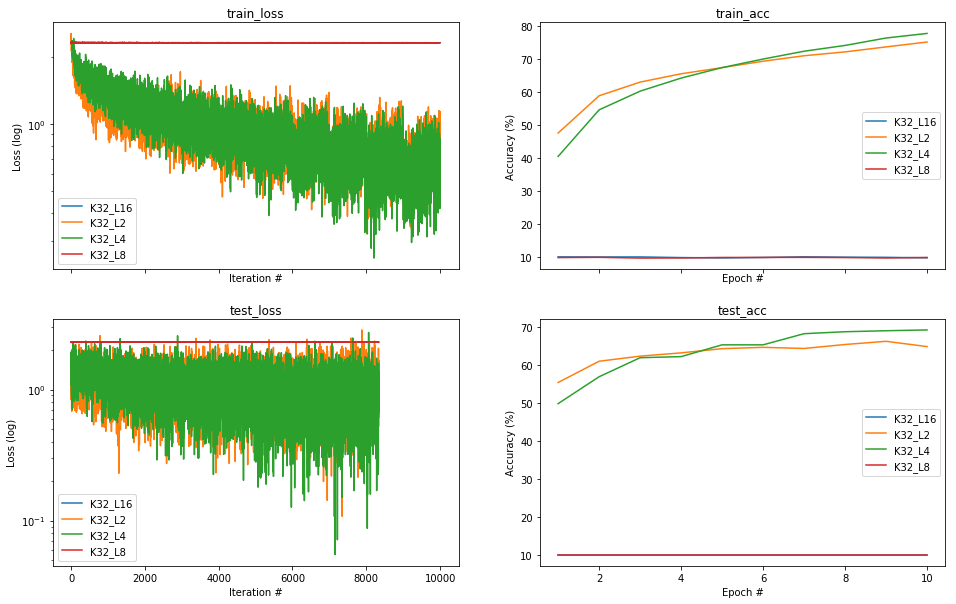

In [33]:
import hw3.experiments as experiments
from hw3.experiments import load_experiment
from helpers.plot import plot_fit
plot_exp_results('exp1_1_K32*.json')

common config:  {'run_name': 'exp1_1_K64_L8', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


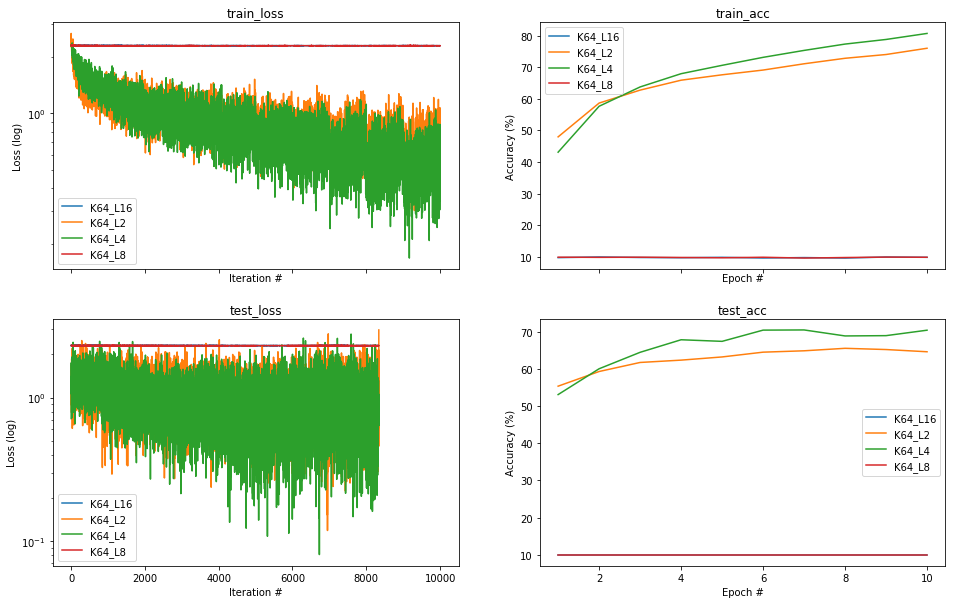

In [34]:
plot_exp_results('exp1_1_K64*.json')

#### Experiment 1.2: Varying the number of filters per layer (`K`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `L=2` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=4` fixed, with `K=[32],[64],[128],[258]` varying per run.
- `L=8` fixed, with `K=[32],[64],[128],[258]` varying per run.

So 12 different runs in total. To clarify, each run `K` takes the value of a list with a single element.

**Naming runs**:
Each run should be named `exp1_2_L{}_K{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_2_L2_K32`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_2_L2_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


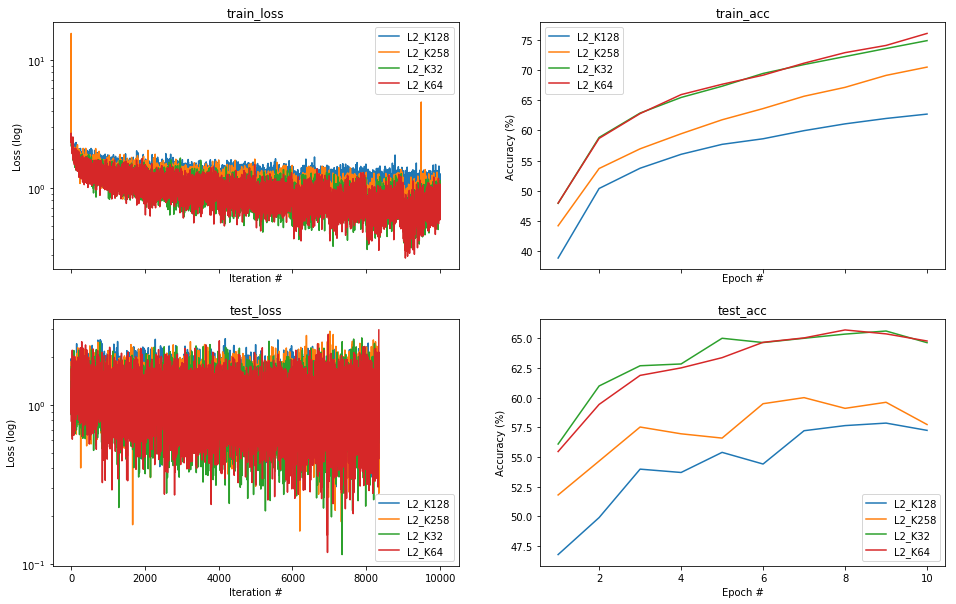

In [35]:
plot_exp_results('exp1_2_L2*.json')

common config:  {'run_name': 'exp1_2_L4_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


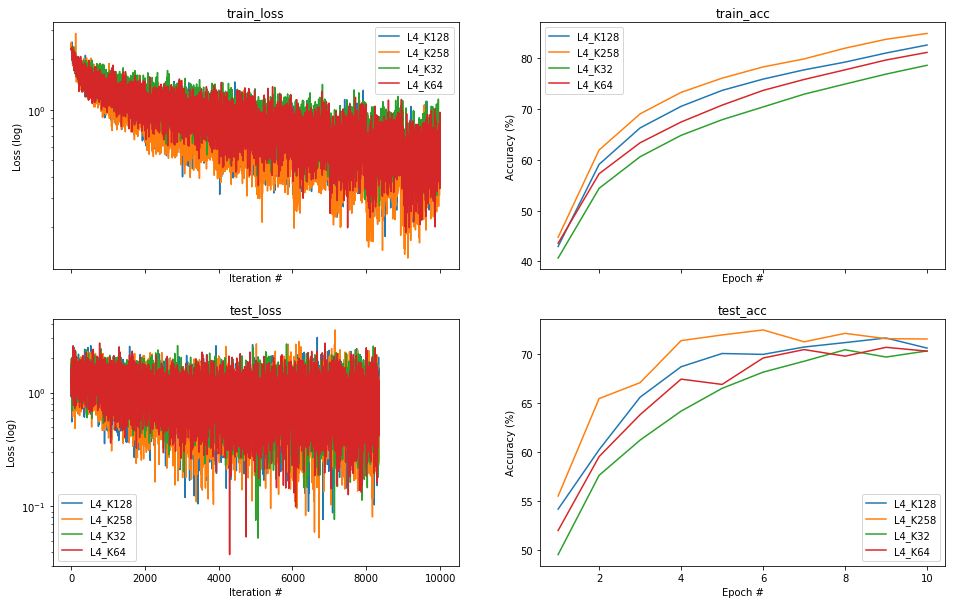

In [36]:
plot_exp_results('exp1_2_L4*.json')

common config:  {'run_name': 'exp1_2_L8_K64', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


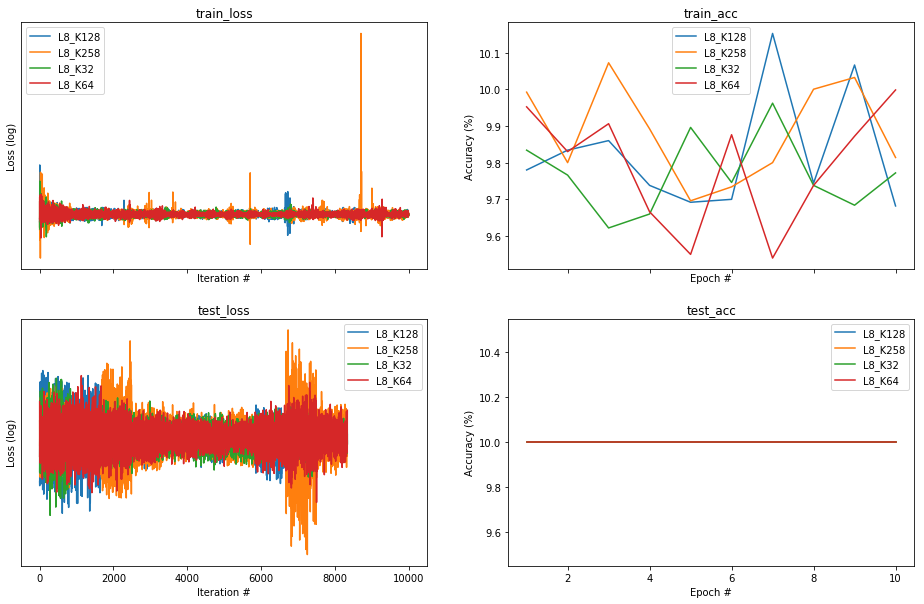

In [37]:
plot_exp_results('exp1_2_L8*.json')

#### Experiment 1.3: Varying both the number of filters (`K`) and network depth (`L`)

Now we'll test the effect of the number of convolutional filters in each layer.

**Configuratons**:
- `K=[64, 128, 256]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a three elements.

**Naming runs**:
Each run should be named `exp1_3_L{}_K{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp1_3_L1_K64-128-256`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results.

common config:  {'run_name': 'exp1_3_L4_K64-128-256', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': False, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


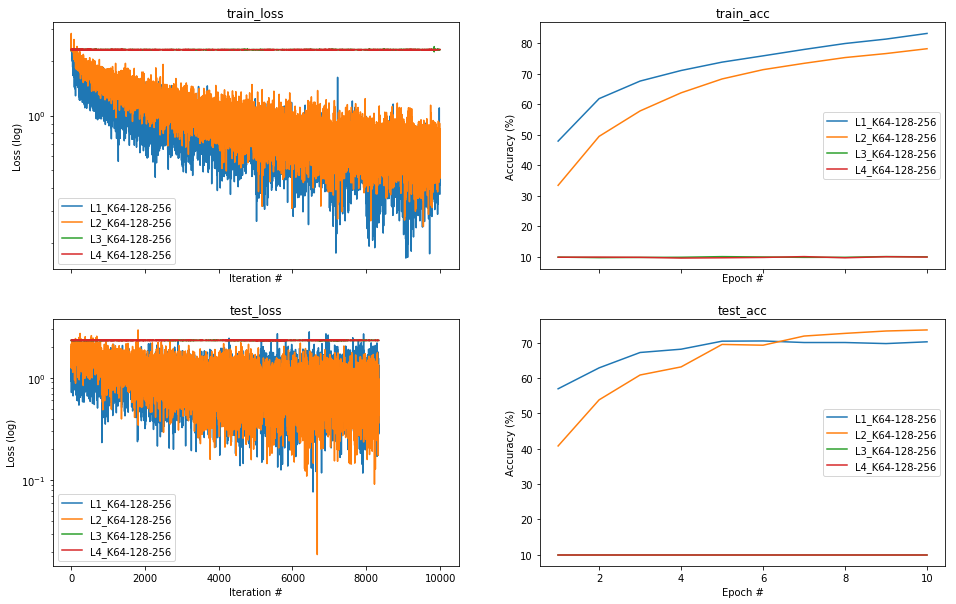

In [38]:
plot_exp_results('exp1_3*.json')

### Experiment 2 - Custom network architecture

In this part you will create your own custom network architecture based on the `ConvClassifier` you've implemented.

Try to overcome some of the limitations your experiment 1 results, using what you learned in the course.

You are free to add whatever you like to the model, for instance 
- Batch normalization
- Dropout layers
- Skip connections
- Change kernel spatial sizes and strides
- Custom blocks or ideas from known architectures (e.g. inception module)

Just make sure to keep the model's `init` API identical (or maybe just add parameters).

**TODO**: Implement your custom architecture in the `YourCodeNet` class within the `hw3/models.py` module.

In [40]:
net = models.YourCodeNet((3,100,100), 10, filters=[32]*4, pool_every=2, hidden_dims=[100]*2).to(device)
print(net)

test_image = torch.randint(low=0, high=256, size=(3, 100, 100), dtype=torch.float).to(device)
test_out = net(test_image.unsqueeze(0))
print('out =', test_out)

################ EXPERIMENT 1.3 ########################
K = [64, 128, 256, 512]
L = [1,2,3,4]

for layers_per_blk in L:
    print("~~~~~~~~~~ RUNNING EXP 2 " + "_L" + str(layers_per_blk))
    test_name = "exp2_L" + str(layers_per_blk) + "_K64-128-256-512"
    experiments.run_experiment(test_name, seed=seed, bs_train=50, batches=10, epochs=10, early_stopping=5,
                       filters_per_layer=K, layers_per_block=layers_per_blk, pool_every=3, hidden_dims=[100],
                           ycn=True)



YourCodeNet(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Dropout(p=0.2)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Dropout(p=0.2)
    (17): MaxPool2d(kernel_size=2, stride=2, p

test_batch (Avg. Loss 1.712, Accuracy 34.6): 100%|██████████| 834/834 [00:10<00:00, 78.89it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 1.439, Accuracy 46.9): 100%|██████████| 834/834 [00:10<00:00, 77.23it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.051, Accuracy 63.4): 100%|██████████| 834/834 [00:10<00:00, 81.26it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 0.946, Accuracy 67.2): 100%|██████████| 834/834 [00:10<00:00, 78.50it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 0.847, Accuracy 71.0): 100%|██████████| 834/834 [00:10<00:00, 78.24it/s]
--- EPOCH 6/10 ---
test_batch (Avg. Loss 0.897, Accuracy 68.3): 100%|██████████| 834/834 [00:10<00:00, 80.08it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 0.735, Accuracy 75.4): 100%|██████████| 834/834 [00:10<00:00, 77.83it/s]
--- EPOCH 8/10 ---
test_batch (Avg. Loss 0.732, Accuracy 75.0): 100%|██████████| 834/834 [00:10<00:00, 82.05it/s]
--- EPOCH 9/10 ---
test_batch (Avg. Loss 0.657, Accuracy 77.3): 100%|██████████| 834/834 [00:10<00:00, 80.0

test_batch (Avg. Loss 1.914, Accuracy 30.3): 100%|██████████| 834/834 [01:20<00:00, 11.90it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 1.809, Accuracy 35.6): 100%|██████████| 834/834 [01:19<00:00, 10.47it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.919, Accuracy 33.2): 100%|██████████| 834/834 [01:18<00:00, 10.60it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 1.518, Accuracy 43.3): 100%|██████████| 834/834 [01:18<00:00, 10.69it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 1.339, Accuracy 51.5): 100%|██████████| 834/834 [01:17<00:00, 10.78it/s]
--- EPOCH 6/10 ---
test_batch (Avg. Loss 1.043, Accuracy 64.3): 100%|██████████| 834/834 [01:17<00:00, 10.78it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 1.013, Accuracy 64.0): 100%|██████████| 834/834 [01:16<00:00, 10.87it/s]
--- EPOCH 8/10 ---
test_batch (Avg. Loss 1.105, Accuracy 60.8): 100%|██████████| 834/834 [01:17<00:00, 10.81it/s]
--- EPOCH 9/10 ---
test_batch (Avg. Loss 0.988, Accuracy 66.2): 100%|██████████| 834/834 [01:16<00:00, 12.4

test_batch (Avg. Loss 2.094, Accuracy 23.5): 100%|██████████| 834/834 [01:59<00:00,  6.98it/s]
--- EPOCH 2/10 ---
test_batch (Avg. Loss 1.576, Accuracy 38.0): 100%|██████████| 834/834 [01:58<00:00,  7.04it/s]
--- EPOCH 3/10 ---
test_batch (Avg. Loss 1.523, Accuracy 48.6): 100%|██████████| 834/834 [01:57<00:00,  7.11it/s]
--- EPOCH 4/10 ---
test_batch (Avg. Loss 1.418, Accuracy 51.0): 100%|██████████| 834/834 [01:56<00:00,  7.15it/s]
--- EPOCH 5/10 ---
test_batch (Avg. Loss 1.467, Accuracy 48.7): 100%|██████████| 834/834 [01:56<00:00,  7.18it/s]
--- EPOCH 6/10 ---
test_batch (Avg. Loss 1.312, Accuracy 56.2): 100%|██████████| 834/834 [01:55<00:00,  7.19it/s]
--- EPOCH 7/10 ---
test_batch (Avg. Loss 1.197, Accuracy 61.8): 100%|██████████| 834/834 [01:56<00:00,  7.19it/s]
--- EPOCH 8/10 ---
test_batch (Avg. Loss 1.087, Accuracy 68.3): 100%|██████████| 834/834 [01:55<00:00,  7.19it/s]
--- EPOCH 9/10 ---
test_batch (Avg. Loss 1.079, Accuracy 67.3): 100%|██████████| 834/834 [01:56<00:00,  7.1

#### Experiment 2 Configuration

Run your custom model on at least the following:

**Configuratons**:
- `K=[64, 128, 256, 512]` fixed with `L=1,2,3,4` varying per run.

So 4 different runs in total. To clarify, each run `K` takes the value of an array with a four elements.

If you want, you can add some extra following the same pattern.
Try to see how deep a model you can train.

**Naming runs**:
Each run should be named `exp2_L{}_K{}-{}-{}-{}` where the braces are placeholders for the values. For example, the first run should be named `exp2_L1_K64-128-256-512`. 

**TODO**: Run the experiment on the above configuration. Make sure the result file names are as expected. Use the following blocks to display the results. To make the experiment runner use your custom network model instead of the previous one, use the `--ycn` argument on the command line.

common config:  {'run_name': 'exp2_L4_K64-128-256-512', 'out_dir': './results', 'seed': 42, 'bs_train': 50, 'bs_test': 12, 'batches': 10, 'epochs': 10, 'early_stopping': 5, 'checkpoints': None, 'lr': 0.001, 'reg': 0.001, 'pool_every': 3, 'hidden_dims': [100], 'ycn': True, 'kw': {}, 'loss_fn': 'CrossEntropyLoss', 'optimizer': 'Adam'}


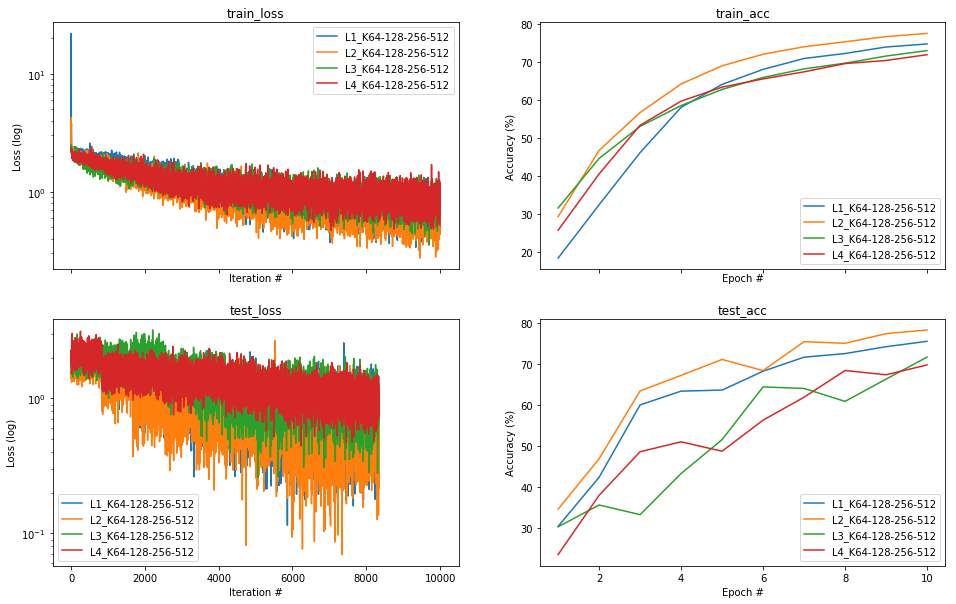

In [41]:
plot_exp_results('exp2*.json')

## Questions
<a id=part3_4></a>

**TODO** Answer the following questions. Write your answers in the appropriate variables in the module `hw3/answers.py`.

In [7]:
from helpers.answers import display_answer
import hw3.answers

### Question 1 

Analyze your results from experiment 1.1. In particular,
1.  Explain the effect of depth on the accuracy. What depth produces the best results and why do you think that's the case?
1. Were there values of `L` for which the network wasn't trainable? what causes this? Suggest two things which may be done to resolve it at least partially.

In [12]:
display_answer(hw3.answers.part3_q1)


**Answer TODO:**
- didn't explain why L=2 is best
**Answer:**
We see that network wasn't trainable for
$\left(K,L\right)\in\left\{\left(32,8\right),\left(32,16\right),\left(64,16\right)\right\}$.
For trainable configurations the difference in highest accuracy of different Ls
is small (for the same $K$), with a tiny advantage to lower $L$ values - the best
was $L=2$ and second best $L=4$. Also, the lower the $L$ the faster the learning.
The reason that some networks were not trainable is the ratio $L/K$ was too big.
Each Conv layer with kernel size $k=3$ produces an output where each “pixel” is
some weighted average of 9 input pixels, and the effect of a single input pixel
slowly propogates to farther output pixel when there more layers per block
(bigger $L$). For example, with $K=32$ and looking at the pixels $x_{1,1}$ and
$x_{32,3$2}$ (two opposite corners of the image feature map), then $x_{1,1}$ affects
as far as the $\left(15,15\right)$-th output pixel of the 8th Conv layer and
$x_{32,32}$ affects as far as the $\left(18,18\right)$-th output pixel. In the
output of the 16th Conv layer, already every coordinate of the output is
affected by every coordinate of $x$. At the end, we aren't looking at local
features anymore, but global ones. Recall that Conv layers are effective
because they enable the model to learn local features, hence the globalizing
effect of too large $L$ negates the effectiveness.
The reason that $L=2$ gave the best results on the test set is the fact that pooling layers are more 
common in that architecture which converse more local spatial invariancy for the features extracet by
the convolution layer and the fact that there far less learnable parameters in this architecture to
manage effective learning on relative small dataset such as the one we are using, as opposed to 
the deeper architectures that use pooling after deeper convolution-relu blocks and have far more
adjustable weights which may cause underfitting.
One option to resolve it is too increase $K$, and we see that it does help -
$K=32,L=8$ wasn't trainable but $K=64,L=8$ was.
A second option is to introduce pooling layers inside convolution blocks,
instead of just between convolution blocks.
Another option is to introduce dropout after Conv layers. Dropout introduces
redundancy into the network, which means in a single layer the same local
features are learned at different weights. When looking at the deeper layers,
they do weighted on a smaller number of distinct features, so the globalizing
effect explained earlier is smaller.


### Question 2 

Analyze your results from experiment 1.2. In particular, compare to the results of experiment 1.1.

In [9]:
display_answer(hw3.answers.part3_q2)


**Answer:**
All the networks were trainable, and as $K$ is larger than in the previous
experiment that is no surprise.
For $L=2$, the best result is for $K=64$. For $L=4$ and $L=8$, the best is
$K=2$56 with $K=128$ being a close second. The reason is that higher $K$
enables learning a bigger amount of local features (more filters), and larger
$L$ enables learning how the local features combine into less-local features.
The small $L=2$ doesn't allow enough depth for complicated combination of
refined local features, and instead favors combination of cruder local
features, which is why the best $L$ is 64 and not 128 or 256. The larger $L=4$
and $L=8$ allow more complicated combinations of more refined local features,
hence the larger $K$ values are better.


### Question 3 

Analyze your results from experiment 1.3.

In [10]:
display_answer(hw3.answers.part3_q3)


**Answer:**
No network was trainable, since the network is too deep to be trained without max-pooling


### Question 4 

1. Explain your modifications to the architecture which you implemented in the `YourCodeNet` class.
2. Analyze the results of experiment 2. Compare to experiment 1.

In [11]:
display_answer(hw3.answers.part3_q4)


**Answer:**
The following changes were introduced to the network:
1. An nn.BatchNorm2d layer was added after each nn.Conv2d layer
2. An nn.Dropout layer with p=0.2 was added after each nn.Relu layer in the feature extractor block
3. An nn.Dropout layer with p=0.2 was added after each nn.Relu layer in the classifier block
Those changes were supposed to support better training since Dropout is known
to helping prevent overfit (introduce redundancy, effectively training more
models simultaneously) and BatchNorm is known to be a good technique for better
gradient flow (mitigates exploding/vanishing gradients, faster training).
All the networks were trained successfully, and achieved better results than
the original architecture. It isn't clear if the best results are produced by
$L=2$, $L=3$ or $L=4$, but $L=4$ had the least amount of overfit (or perhaps
was underfitted), suggesting more epochs could increase its test accuracy more
than the rest.
